In [2]:
### Set CUDA device
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [3]:
import numpy as np
import torch
from torch import Tensor, nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from torchvision.transforms import GaussianBlur
from torchmetrics.functional.classification import dice

## Augmentations
from batchgenerators.transforms.noise_transforms import augment_gaussian_blur


sys.path.append('../')
from data_utils import get_eval_data
from model.unet import get_unet
from utils import  epoch_average
# from losses import (
#     DiceScoreCalgary, 
#     DiceScoreMMS
# )

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [5]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

In [6]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr


unet_name = 'default-8'
postfix = '_no-blurring'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name + postfix
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = int(args[1])

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])


unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda()

In [21]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = False
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = [] #'all'


data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

print(f'\nAvailable datasets are: {list(data.keys())}')

loading dataset
loading all case properties

Available datasets are: ['train']


In [22]:
dataloader = DataLoader(data['train'], 
    batch_size=32, 
    shuffle=False, 
    drop_last=False
)

In [23]:
truncate=4.0
sigma = 1
radius = round(truncate * sigma)
kernel_size = 2*radius + 1

kernel_size

9

In [24]:
@torch.no_grad()
def eval_heart_set(
    model: nn.Module, 
    dataloader: DataLoader, 
) -> Dict:
    model.eval()
    
    # Gaussian Params (from gaussian_filter, scipy)
    blurs = []
    truncate=4.0

    DSCs = {'0': []}
    for sigma in torch.linspace(0.5, 3, 5):
        DSCs[str(sigma.item())] = []
        radius = round(truncate * sigma.item())
        kernel_size = 2*radius + 1
        blurs.append(
            GaussianBlur(
                kernel_size=kernel_size,
                sigma=sigma.item()
            )    
        )

    # saves batch sizes for each batch for averaging
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target'].long()
        # convert -1 labels to background
        target[target == -1] = 0
        # # convert to one-hot encoding
        # target = F.one_hot(
        #     target.long(), 
        #     num_classes=4
        # ).squeeze(1).permute(0,3,1,2)
        # get model output
        net_out_original = model(input_.cuda()).detach().cpu()
        segmap_original = torch.argmax(net_out_original, dim=1, keepdims=True)
        DSCs['0'].append(
            torch.tensor([dice(
                    s.flatten(), 
                    t.flatten(),
                    num_classes=4,
                    zero_division=1,
                    average='macro'
                ) for s,t in zip(segmap_original, target)]
            ).cpu()
        )
        for blur in blurs:
            input_augmented = blur(input_)

            net_out_augmented = model(input_augmented.cuda()).detach().cpu()
            segmap_augmented = torch.argmax(net_out_augmented, dim=1, keepdims=True)
            DSCs[str(blur.sigma[1])].append(
                torch.tensor([dice(
                        s.flatten(), 
                        t.flatten(),
                        num_classes=4,
                        zero_division=1,
                        average='macro'
                    ) for s,t in zip(segmap_augmented, target)]
                ).cpu()
            )

    return DSCs


In [25]:
DSCs = eval_heart_set(
    model=unet, 
    dataloader=dataloader
)

KeyboardInterrupt: 

In [28]:
for key in DSCs:
    # DSCs[key] = torch.cat(DSCs[key])
    print(f'{key}: {DSCs[key].mean()}')


0: 0.9215230345726013
0.5: 0.9224403500556946
1.125: 0.8887324333190918
1.75: 0.8569796681404114
2.375: 0.8031411170959473
3.0: 0.7833218574523926


In [29]:
class DomainshiftAugmenter(nn.Module):
    def __init__(self, augments: List[nn.Module]):
        super(DomainshiftAugmenter, self).__init__()
        self.augments = augments
    
    def forward(self, x: Tensor):
        return [aug(x) for aug in self.augments]
    

def get_gaussian_domainshift_augments(
    sigmas: List[float],
    truncate: float = 4.0,
) -> List[nn.Module]:
    radius = round(truncate * sigma)
    kernel_size = 2*radius + 1

    return [
        GaussianBlur(
            kernel_size=kernel_size,
            sigma=sigma
        ) for sigma in sigmas
    ]

In [30]:
augs = get_gaussian_domainshift_augments(
    sigmas = [0.5 * i for i in range(1, 7)]
)

domainshift_augmenter = DomainshiftAugmenter(augs)

In [31]:
def get_domainshift_flips(
    output_id: Tensor,
    output_ood: List[Tensor],
    net_out: str
):  
    if net_out == 'brain':
        segmap_id = (torch.sigmoid(output_id) > 0.5) * 1
        segmap_ood = (torch.sigmoid(output_ood) > 0.5) * 1

    elif net_out == 'heart':
        segmap_id = torch.argmax(output_id, dim=1, keepdims=True)
        segmap_ood = torch.argmax(output_ood, dim=1, keepdims=True)

    return segmap_id != segmap_ood


In [58]:
class UMapGenerator(nn.Module):
    """
    Calculates uncertainty maps from UNets in different ways.
    
    PyTorch Module to generate uncertainty maps from
    * VAE samples
    * Entropy in drop out samples
    * Entropy in model outputs
    """
    
    def __init__(
        self,
        method: str,  # 'ae'
        net_out: str,  # 'mms' or 'calgary'
    ):
        super().__init__()
        self.method  = method
        self.net_out = net_out
        self.m       = nn.Softmax(dim=1) if net_out=='heart' else nn.Sigmoid()
        self.ce      = nn.CrossEntropyLoss(reduction='none') if net_out=='heart' else nn.BCEWithLogitsLoss(reduction='none')
        self.kld     = nn.KLDivLoss(reduction='none')
    
    @torch.no_grad()
    def forward(self, x: Tensor, batch_size: int = 1) -> Tensor:
        
        if self.method == 'none':
            return None
        
        x = x.detach()

        #################################
        ### Cross and regular Entropy ###
        #################################

        if self.method == 'cross_entropy':
            umap = self.ce(x[:batch_size], self.m(x[batch_size:]))
            if len(umap.shape) == 3:
                umap = umap.unsqueeze(1)
            # umap = umap.mean(dim=1, keepdims=True)
            
        elif self.method == 'entropy':          
            x_prob = self.m(x[:batch_size])
            umap = torch.special.entr(x_prob).sum(dim=1, keepdims=True)
            # umap = torch.distributions.Categorical(x_prob.permute(0,2,3,1)).entropy().unsqueeze(1)

        elif self.method == 'top2diff':
            x_prob = self.m(x[:batch_size])
            assert len(x_prob.shape) == 4, f"x_prob shape is {x_prob.shape}, but should be (n, c, h, w)"
            x_prob_sorted, _ = x_prob.sort(1)
            umap = 1 - (x_prob_sorted[:, -1:] - x_prob_sorted[:, -2:-1])
            assert len(umap.shape) == 4, f"umap shape is {umap.shape}, but should be (n, 1, h, w)"

        elif self.method == 'kld_entr':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            output_log_prob = torch.log(output_prob + 1e7)
            # output_augmented_prob = self.m(x[batch_size:])
            entropy = torch.special.entr(output_prob)
            # print(f'entropy: {entropy.shape} {entropy.mean()}')
            kld = - self.kld(output_log_prob, output_augmented_prob)
            # print(f'kld: {kld.shape} {kld.mean()}')
            umap = (entropy * kld).sum(dim=1, keepdims=True)

        elif self.method == 'diff_grad':
            output_prob, output_augmented_prob = torch.split(self.m(x), batch_size)
            
        
        #################################
        ### experimental / M&M only   ###
        #################################
    
        elif self.method == 'kl_divergence':
            x_in = F.log_softmax(x[:batch_size], dim=1)
            umap = self.kl(x_in, self.m(x[batch_size:]))
            umap = umap.sum(dim=(1), keepdims=True)
            
        elif self.method == 'mse':
            x      = self.m(x)
            x     -= x.min(dim=1, keepdims=True).values
            x     /= x.sum(dim=1, keepdims=True)
            umap   = torch.pow(x[:batch_size] - x[batch_size:], 2).mean(1, keepdim=True)

        
        assert umap.shape[1] == 1, f"umap shape is {umap.shape}, but should be (n, 1, h, w)"
        return umap

In [54]:
from torch.utils.data import Dataset
from typing import List, Dict, Union
# from utils import UMapGenerator
from torchmetrics.classification import BinaryPrecisionRecallCurve
from sklearn.metrics import auc

def get_precision_recall_for_domainshift_flips(
    model: nn.Module, 
    dataset: Dataset, 
    net_out: str, 
    umap: str,
    domain_shift_aug: nn.Module,
    n_taus: Union[str, int] = 'auto',
    device=['cuda:0', 'cpu']
):
    model.eval()
    
    batch_size = 32

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        drop_last=True
    )

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device[0])

    umaps   = []
    errmaps = []

    for _, batch in enumerate(dataloader):

        input_ = batch['input'].to(device[0])
        input_augmented = domain_shift_aug(input_)

        model.set_transform(False)
        output_id = model(input_)
        output_ood = model(input_augmented)
        model.set_transform(True)
        output_ood_transformed = model(input_augmented)

        if net_out == 'brain':
            segmap_id = (torch.sigmoid(output_id) > 0.5) * 1
            segmap_ood = (torch.sigmoid(output_ood) > 0.5) * 1
            errmap = (segmap_id != segmap_ood).float()
        elif net_out == 'heart':
            segmap_id = torch.argmax(output_id, dim=1, keepdims=True)
            segmap_ood = torch.argmax(output_ood, dim=1, keepdims=True)
            errmap = (segmap_id != segmap_ood).float()
        umaps.append(
            umap_generator(
                torch.cat([output_ood, output_ood_transformed], dim=0), 
                batch_size=batch_size
            ).cpu()
        )
        errmaps.append(errmap.cpu())

    umaps = torch.cat(umaps, dim=0).flatten().half()
    umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
    errmaps = torch.cat(errmaps, dim=0).flatten().to(torch.uint8)

    # in case of manual threshold selection
    if n_taus != 'auto':
        # taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)**(1/16)).tolist()
        taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)).tolist()
    elif n_taus == 'auto':
        taus = None

    # TODO: Change to torcheval once its stable :)
    # bprc = torcheval.metrics.BinaryPrecisionRecallCurve()
    bprc = BinaryPrecisionRecallCurve(thresholds = taus).to(device[1])
    pr = bprc(umaps.to(device[1]), errmaps.to(device[1]))
    if device[1] != 'cpu':
        pr = tuple(map(lambda x: x.cpu(), pr))

    pr_auc = auc(pr[1], pr[0])

    # subset precision/recall to 100 points for plotting
    # we find indices along the x axis (recall) such that they
    # have roughly equal distance to each other and select the 
    # corresponding y values (precision)
    p, r, _= pr  
    # find indices for sorting in recall
    indices = np.argsort(r)
    # sort precision and recall similarly
    r_sorted, p_sorted = (r[indices], p[indices])
    # select target values for recall
    target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
    # find best matches in sorted recall, that are smaller or equal to the target values
    subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
    # select precision and recall at the best matches
    r_sampled, p_sampled = (
        r_sorted[subset_indices], 
        p_sorted[subset_indices]
    )

    return p_sampled, r_sampled, pr_auc




@torch.no_grad()
def get_precision_recall_for_domainshift_flips_model(
    model: nn.Module, 
    dataset: Dataset, 
    net_out: str, 
    dae: bool,
    umap: str,
    domain_shift_aug: nn.Module,
    n_taus: Union[str, int] = 'auto',
    device=['cuda:0', 'cpu']
):
    if dae == True:
        # Remove trainiung hooks, add evaluation hooks
        model.remove_all_hooks()        
        model.hook_inference_transformations(model.transformations, n_samples=1)
        # Put model in evaluation state
        model.to(device[0])
        model.freeze_seg_model()
    model.eval()
    
    batch_size = 32

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        drop_last=True
    )

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device[0])

    umaps   = []
    errmaps = []

    for _, batch in enumerate(dataloader):

        input_ = batch['input'].to(device[0])
        input_augmented = domain_shift_aug(input_)

        output_id = model(input_)
        output_ood = model(input_augmented)

        if net_out == 'brain':
            segmap_id = (torch.sigmoid(output_id) > 0.5) * 1
            segmap_ood = (torch.sigmoid(output_ood) > 0.5) * 1
            errmap = (segmap_id != segmap_ood).float()
        elif net_out == 'heart':
            segmap_id = torch.argmax(output_id, dim=1, keepdims=True)
            segmap_ood = torch.argmax(output_ood, dim=1, keepdims=True)
            errmap = (segmap_id != segmap_ood).float()
        umaps.append(
            umap_generator(
                output_ood,
                batch_size=batch_size
            ).cpu()
        )
        errmaps.append(errmap.cpu())

    umaps = torch.cat(umaps, dim=0).flatten().half()
    umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
    errmaps = torch.cat(errmaps, dim=0).flatten().to(torch.uint8)

    # in case of manual threshold selection
    if n_taus != 'auto':
        # taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)**(1/16)).tolist()
        taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)).tolist()
    elif n_taus == 'auto':
        taus = None

    # TODO: Change to torcheval once its stable :)
    # bprc = torcheval.metrics.BinaryPrecisionRecallCurve()
    bprc = BinaryPrecisionRecallCurve(thresholds = taus).to(device[1])
    pr = bprc(umaps.to(device[1]), errmaps.to(device[1]))
    if device[1] != 'cpu':
        pr = tuple(map(lambda x: x.cpu(), pr))

    pr_auc = auc(pr[1], pr[0])

    # subset precision/recall to 100 points for plotting
    # we find indices along the x axis (recall) such that they
    # have roughly equal distance to each other and select the 
    # corresponding y values (precision)
    p, r, _= pr  
    # find indices for sorting in recall
    indices = np.argsort(r)
    # sort precision and recall similarly
    r_sorted, p_sorted = (r[indices], p[indices])
    # select target values for recall
    target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
    # find best matches in sorted recall, that are smaller or equal to the target values
    subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
    # select precision and recall at the best matches
    r_sampled, p_sampled = (
        r_sorted[subset_indices], 
        p_sorted[subset_indices]
    )

    return p_sampled, r_sampled, pr_auc

In [42]:
from model.mahalanobis_adatper import (
    get_pooling_mahalanobis_detector, 
    get_batchnorm_mahalanobis_detector
)

augs = get_gaussian_domainshift_augments(
    sigmas = [0.5 * i for i in range(1, 7)]
)


mahalanobis_detector = get_pooling_mahalanobis_detector(
    swivels=['up3.0.conv_path.0.bn'],
    unet=unet,
    sigma_algorithm='default',
    fit='raw',
    iid_data=dataloader,
    transform=True,
    lr=5e1,
    device='cuda:0'
)

for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='cross_entropy',
        domain_shift_aug=aug,
        n_taus='auto',
        
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")

0.5: 0.20214003324508667
1.0: 0.31817156076431274
1.5: 0.3500712513923645
2.0: 0.3798588812351227
2.5: 0.39080309867858887
3.0: 0.3968576192855835


In [60]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

mahalanobis_detector = get_batchnorm_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    reduce=False,
    aggregate='mean',
    transform=True,
    lr=1e5,
    device='cuda:0'
)

for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='cross_entropy',
        domain_shift_aug=aug,
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")

0.5: 0.203425794839859
1.0: 0.332897812128067
1.5: 0.3726859390735626
2.0: 0.407044917345047
2.5: 0.42340371012687683
3.0: 0.4345472753047943


In [49]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

mahalanobis_detector = get_batchnorm_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    reduce=False,
    aggregate='mean',
    transform=True,
    lr=5e5,
    device='cuda:0'
)

for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='cross_entropy',
        domain_shift_aug=aug,
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")

0.5: 0.19338887929916382
1.0: 0.35372358560562134
1.5: 0.40775763988494873
2.0: 0.4415822923183441
2.5: 0.4726722240447998
3.0: 0.49544423818588257


In [59]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

mahalanobis_detector = get_batchnorm_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    reduce=False,
    aggregate='mean',
    transform=True,
    lr=5e5,
    device='cuda:0'
)

for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='kld_entr',
        domain_shift_aug=aug,
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")

0.5: 0.3302971422672272
1.0: 0.373517781496048
1.5: 0.3884768784046173
2.0: 0.4094115197658539
2.5: 0.4169321656227112
3.0: 0.4249515235424042


In [38]:
for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips_model(
        model=unet, 
        dataset=data['train'], 
        net_out='heart', 
        umap='entropy',
        domain_shift_aug=aug,
        n_taus='auto',
        dae=False,
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")

0.5: 0.20288245379924774
1.0: 0.3227595388889313
1.5: 0.3571259081363678
2.0: 0.38532742857933044
2.5: 0.3961462378501892
3.0: 0.4028383195400238


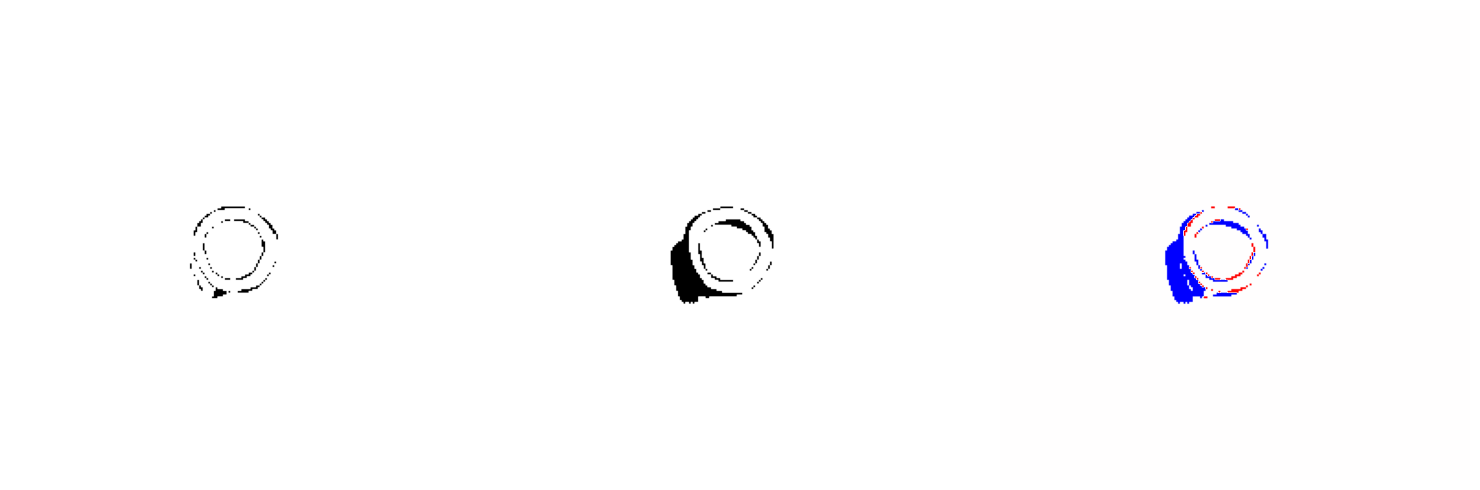

In [124]:
idx = 17


truncate = 4
sigma = 3
radius = round(truncate * sigma)
kernel_size = 2*radius + 1
augmenter = GaussianBlur(
    kernel_size=kernel_size,
    sigma=sigma
)    

ds = data['train'][idx]
img = ds['input']
img_augmented = augmenter(img.unsqueeze(0)).squeeze(0)
target = ds['target'].unsqueeze(0)
target[target == -1] = 0
out = unet(
    torch.stack([img, img_augmented], dim=0).cuda()
).detach().cpu()
segmap = torch.argmax(out, dim=1, keepdims=True)
errmap = (segmap != target).squeeze()

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(errmap[0], cmap='Greys')
axes[1].imshow(errmap[1], cmap='Greys')
axes[2].imshow(errmap[0]*1 - errmap[1]*1, cmap='bwr')

for ax in axes.ravel():
    ax.set_axis_off()
plt.tight_layout()

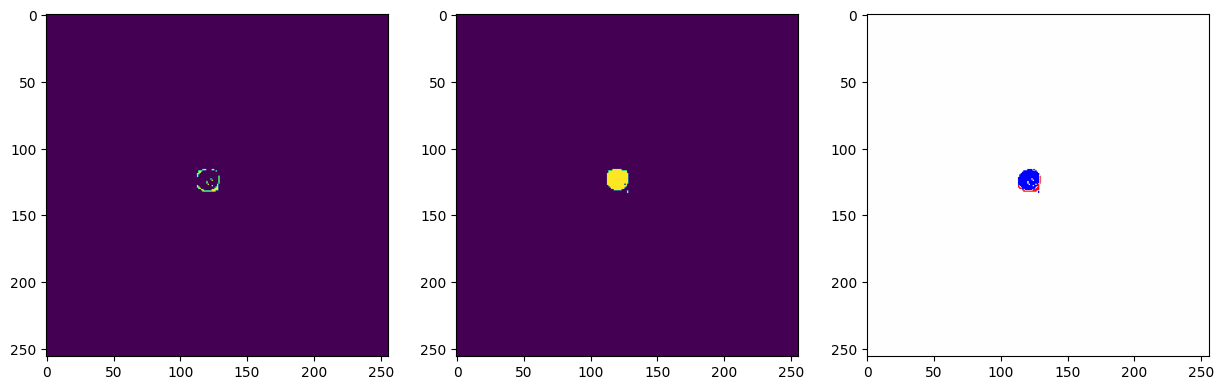

In [115]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(errmap[0])
ax[1].imshow(errmap[1])
ax[2].imshow(errmap[0]*1 - errmap[1]*1, cmap='bwr')

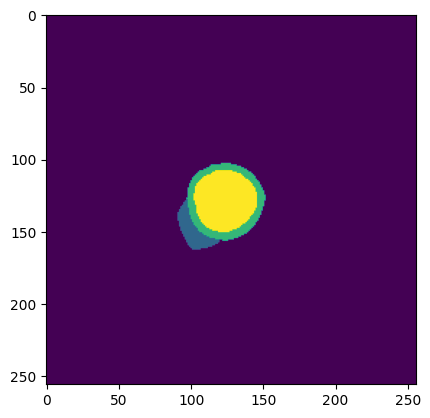

In [91]:
plt.imshow(segmap[0].squeeze().numpy())

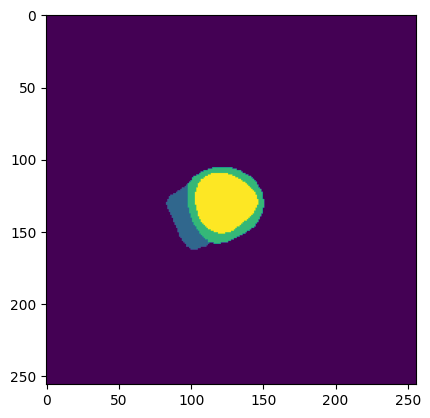

In [92]:
plt.imshow(segmap[1].squeeze().numpy())

In [ ]:
## Original Augmentation + Params from Batchgenerators

# input_augmented = augment_gaussian_blur(
#     data_sample=input_ ,
#     sigma_range=sigma,
#     per_channel=True,
#     p_per_channel=1,
#     different_sigma_per_axis=False,
#     p_isotropic=0
# )

## Original Eval Function

# @torch.no_grad()
# def eval_heart_set(
#     model: nn.Module, 
#     dataloader: DataLoader, 
#     eval_metrics: Dict
# ) -> Dict:
#     model.eval()
#     epoch_metrics = {key: [] for key in eval_metrics.keys()}
#     # saves batch sizes for each batch for averaging
#     batch_sizes = []
#     for batch in dataloader:
#         input_ = batch['input']
#         target = batch['target'].cuda()
#         # convert -1 labels to background
#         target[target == -1] = 0
#         # convert to one-hot encoding
#         target = F.one_hot(
#             target.long(), 
#             num_classes=4
#         ).squeeze(1).permute(0,3,1,2)
#         # get model output
#         net_out = model(input_.cuda())
        
#         batch_sizes.append(input_.shape[0])
#         for key, metric in eval_metrics.items():
#             epoch_metrics[key].append(
#                 metric(net_out, target).detach().mean().cpu()
#             )
            
#     for key, epoch_scores in epoch_metrics.items():
#         epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)
        
#     return epoch_metrics